In [1]:
#Imports
import os
import re
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
import nltk

2025-09-29 23:05:54.312268: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-29 23:05:54.325478: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759197954.341219   73860 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759197954.348436   73860 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1759197954.360288   73860 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
#Configurações e hiperparâmetros

#FILE_O: arquivo bruto (raw) com todo o corpus
#FILE_L: arquivo que conterá o texto limpo

FILE_O = '../gutenberg_concat.txt'
FILE_L = 'gutenberg_concat_clean.txt'
# FILE_O = '../medium_concat.txt'
# FILE_L = 'medium_concat_clean.txt'
# FILE_O = '../internet_archive_scifi_v3.txt'
# FILE_L = 'internet_archive_scifi_v3_clean.txt'

#Parâmetros do dataset e do treino
SEQ_LEN = 200              #Comprimento da sequência de entrada
STEP = 1                   #Passo para construir sequências
BATCH_SIZE = 32            #Tamanho do lote para treinamento
EPOCHS = 4                 #Número de épocas de treinamento
EMB_DIM = 16               #Dimensão do embedding de caracteres
LSTM_UNITS = 128           #Número de unidades LSTM
MODEL_CHECKPOINT = 'char_model_best_heavy.keras'  #Arquivo para salvar/recuperar o modelo
SHUFFLE_BUFFER_SIZE = 10000
TREINO = True              #Se True, executa o treinamento, se False, carrega modelo e não treina

SEED = 35
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
#Função limpaTexto e gerenciamento de arquivo limpo

def limpaTexto(path_raw):
    """
    Lê o arquivo bruto em path_raw e aplica limpeza básica:
      - Converte para minúsculas
      - Remove caracteres que não sejam a-z, ponto, vírgula e espaço
      - Colapsa espaços repetidos
    Retorna a string limpa.
    """
    with open(path_raw, 'r', encoding='utf-8', errors='ignore') as f:
        text = f.read()

    text = text.lower()
    #Mantém apenas letras a-z, ponto, vírgula e espaço.
    #Tudo que não corresponder ao regex é substituído por espaço.
    text = re.sub(r'[^a-z., ]', ' ', text)
    #Remove múltiplos espaços
    text = re.sub(r'\s+', ' ', text).strip()
    return text

#Se já existe o arquivo limpo, carrega, caso contrário, cria lendo o RAW e salvando.
if os.path.exists(FILE_L):
    print(f"Arquivo limpo encontrado: {FILE_L}")
    with open(FILE_L, 'r', encoding='utf-8') as f:
        text = f.read()
else:
    #Garante que o arquivo raw exista; se não existir, lança erro para notificar.
    if not os.path.exists(FILE_O):
        raise FileNotFoundError(f"Arquivo raw '{FILE_O}' não encontrado no diretório atual")

    print(f"Arquivo limpo não encontrado. Lendo '{FILE_O}' e aplicando limpeza via regex")
    text = limpaTexto(FILE_O)

    with open(FILE_L, 'w', encoding='utf-8') as f:
        f.write(text)
    print(f"Limpeza concluída e salva em '{FILE_L}'.")

print("Length do arquivo após limpar:", len(text))
print("Trecho:", text[:50])

Arquivo limpo não encontrado. Lendo '../gutenberg_concat.txt' e aplicando limpeza via regex
Limpeza concluída e salva em 'gutenberg_concat_clean.txt'.
Length do arquivo após limpar: 100073640
Trecho: conte do do arquivo livros gutenberg livro .txt th


In [4]:
#Vocabulário (alphabet) e mapeamentos char<->idx

#Define explicitamente o alfabeto aceito pelo modelo.
#A ordem aqui influência os índices (char2idx).
alphabet = list('abcdefghijklmnopqrstuvwxyz., ')

#Dicionários para converter caractere -> índice e índice -> caractere
char2idx = {c: i for i, c in enumerate(alphabet)}
idx2char = {i: c for c, i in char2idx.items()}

vocab_size = len(alphabet)  #Quantidade de tokens únicos

#Converte todo o texto limpo para um array de índices inteiros (um por caractere).
#Essa transformação é necessária para alimentar o TensorFlow.
text_as_int = np.array([char2idx[c] for c in text])

In [5]:
#Construção do tf.data.Dataset e criação de sequências

#Cria um dataset a partir dos inteiros (um elemento por caractere)
dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

#Agrupa os caracteres em sequencias de tamanho SEQ_LEN + 1.
#Cada sequencia tem SEQ_LEN caracteres de entrada + 1 caractere alvo.
sequences = dataset.batch(SEQ_LEN + 1, drop_remainder=True)

def separarInputOutput(chunk):
    """
    Recebe um chunk (tensor de shape (SEQ_LEN+1,)) e retorna:
      - input_text: os primeiros SEQ_LEN elementos (sequência de entrada)
      - target_text: o último elemento (o caractere a prever)
    """
    input_text = chunk[:-1]
    target_text = chunk[-1]
    return input_text, target_text

#Aplica a função de separação para obter pares (input, target)
dataset = sequences.map(separarInputOutput)

#Determina o tamanho total do dataset (número de sequências)
DATASET_SIZE = len(sequences)
VAL_SIZE = DATASET_SIZE // 10   #10% para validação
TRAIN_SIZE = DATASET_SIZE - VAL_SIZE

2025-09-29 23:06:11.161568: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [6]:
#Split treino/validação e preparação dos datasets para performance

#Faz o split simples: os primeiros VAL_SIZE batches vão para validação
val_dataset = dataset.take(VAL_SIZE)
train_dataset = dataset.skip(VAL_SIZE)

#Aplica batching, drop_remainder garante batch com shape fixo para o modelo
train_dataset = (
    train_dataset.batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

val_dataset = (
    val_dataset.batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [7]:
#Construção do modelo ou carregamento de checkpoint

if os.path.exists(MODEL_CHECKPOINT):
    print("Modelo existente encontrado, carregando de:", MODEL_CHECKPOINT)
    model = tf.keras.models.load_model(MODEL_CHECKPOINT)
else:
    print("Nenhum modelo salvo encontrado -> Construindo novo modelo")

    model = models.Sequential([
        layers.Input(shape=(SEQ_LEN,)),                      #Entrada: sequência de inteiros (tamanho SEQ_LEN)
        layers.Embedding(input_dim=vocab_size, output_dim=EMB_DIM),  #Embedding de caracteres
        layers.LSTM(LSTM_UNITS),                             #LSTM que processa a sequência
        layers.Dense(vocab_size, activation='softmax')       #Saída: predição sobre o próximo caractere
    ])

    #Compila com Adam e loss apropriada para rótulos inteiros
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
    model.summary()

#Callback para salvar o melhor modelo (monitorando a loss de treino)
chk = callbacks.ModelCheckpoint(
    MODEL_CHECKPOINT,
    monitor='loss',
    save_best_only=True,
    verbose=1,
    save_weights_only=False  #Salva o modelo completo (arquivos .keras)
)


Nenhum modelo salvo encontrado -> Construindo novo modelo


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 16)        │           464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 29)             │         3,741 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,445 (306.43 KB)

 Trainable params: 78,445 (306.43 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
#Treinamento e relatório de perplexidade

if TREINO:
    print("Treinando/continuando o modelo")
    history = model.fit(
        train_dataset,
        epochs=EPOCHS,
        callbacks=[chk],
        validation_data=val_dataset
    )

    #Pega a loss de validação do último epoch para calcular perplexidade
    final_val_loss = history.history['val_loss'][-1]
    perplexidade = np.exp(final_val_loss)

    print("\n" + "="*30)
    print(f"Loss de Validação Final: {final_val_loss:.4f}")
    print(f"Perplexidade do Modelo: {perplexidade:.4f}")
    print("="*30 + "\n")
else:
    print("Pulando treinamento e usando modelo carregado")


Treinando/continuando o modelo
Epoch 1/4
14002/14002 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 2.1870
Epoch 1: loss improved from inf to 1.98676, saving model to char_model_best_heavy.keras
14002/14002 ━━━━━━━━━━━━━━━━━━━━ 735s 52ms/step - loss: 2.1870 - val_loss: 1.7806
Epoch 2/4
14002/14002 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 1.7415
Epoch 2: loss improved from 1.98676 to 1.70833, saving model to char_model_best_heavy.keras
14002/14002 ━━━━━━━━━━━━━━━━━━━━ 755s 53ms/step - loss: 1.7415 - val_loss: 1.6623
Epoch 3/4
14001/14002 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 1.6359
Epoch 3: loss improved from 1.70833 to 1.61901, saving model to char_model_best_heavy.keras
14002/14002 ━━━━━━━━━━━━━━━━━━━━ 756s 53ms/step - loss: 1.6359 - val_loss: 1.6123
Epoch 4/4
14001/14002 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 1.5805
Epoch 4: loss improved from 1.61901 to 1.56905, saving model to char_model_best_heavy.keras
14002/14002 ━━━━━━━━━━━━━━━━━━━━ 770s 54ms/step - loss: 1.5805 - val_loss: 

In [9]:
#Funções auxiliares para predizer próxima letra e gerar texto

def sample(preds, temperature=1.0):
    """
    preds: vetor de probabilidades (saída do modelo)
    temperature: controla aleatoriedade; valores <1 tornam distribuição menos aleatória,
                 valores >1 tornam a distribuição mais aleatória.
    Retorna o índice amostrado/predito (int).
    """
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds + 1e-8) / float(temperature)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    #Amostragem categórica a partir da distribuição resultante
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)


def generate(model, seed, length=400, temperature=1.0):
    """
    Gera texto usando o modelo treinado.
    - model: modelo Keras que toma sequências de inteiros e retorna probabilidades sobre o próximo caractere.
    - seed: string inicial para condicionar a geração
    - length: número de caracteres a gerar
    - temperature: parâmetro de amostragem (passado para sample)

    Retorna a string gerada (seed + caracteres amostrados).
    """
    seed = seed.lower()
    #Aplica mesma limpeza que no treinamento para garantir compatibilidade
    seed = re.sub(r'[^a-z ]', ' ', seed)
    seed = re.sub(r'\s+', ' ', seed).strip()
    if len(seed) == 0:
        seed = ' '  #Caso seed vazia, usa espaço como contexto neutro

    #Ajusta seed para ter exatamente SEQ_LEN caracteres: preenche à esquerda com espaços
    if len(seed) < SEQ_LEN:
        seed = (' ' * (SEQ_LEN - len(seed))) + seed
    else:
        seed = seed[-SEQ_LEN:]  #Usa apenas os últimos SEQ_LEN caracteres

    generated = seed
    for _ in range(length):
        #Converte seed para array de índices
        xpred = np.array([[char2idx[c] for c in seed]])

        #Prediz probabilidades para o próximo caractere
        preds = model.predict(xpred, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = idx2char[next_index]
        generated += next_char

        #Desliza a seed (remove primeiro char e anexa o novo)
        seed = seed[1:] + next_char

    return generated


In [10]:
seed = "the king and the princess"
print("Texto gerado:")
print(generate(model, seed, length=400, temperature=0.5))

Texto gerado:
                                                                                                                                                                               the king and the princess of the facting of the never present of the begund of the best of the fire, there s see to the first and recoff. a fore the first at the man was something to the tents of the other of or the never man seemed three a metting of carrow of the desoled my meant the from the chir the first about me belong in the same to the great up the pile of the copy of the particulara draw to the bather was a pall 


- Armezenamento dos valores de loss em treino e validação

In [ ]:
#Exibir gráfico de loss

#Como a execução foi feita em partes (1º Gutenberg, 2º Medium, 3º Scifi)
#As losses foram salvas em células diferentes e variáveis diferentes
#Obs.: O treinamento foi continuado!
val_loss = history.history['val_loss']
train_loss = history.history['loss']

val_loss1 = val_loss
train_loss1 = train_loss

val_loss1, train_loss1

([1.8091387748718262, 1.7275757789611816],
 [1.9730134010314941, 1.7585424184799194])

In [ ]:
# val_loss = history.history['val_loss']
# train_loss = history.history['loss']

# val_loss2 = val_loss
# train_loss2 = train_loss

# val_loss2, train_loss2

([1.6529476642608643, 1.6118417978286743],
 [1.718830943107605, 1.632041335105896])

In [ ]:
# val_loss = history.history['val_loss']
# train_loss = history.history['loss']

# val_loss3 = val_loss
# train_loss3 = train_loss

# val_loss3, train_loss3

([1.643356204032898, 1.6293249130249023],
 [1.6762632131576538, 1.6469626426696777])

In [ ]:
#Ao fim, as listas com as losses de cada execução foram concatenadas
train_loss_final = train_loss1 + train_loss2 + train_loss3
val_loss_final = val_loss1 + val_loss2 + val_loss3

train_loss_final, val_loss_final

([1.9730134010314941,
  1.7585424184799194,
  1.718830943107605,
  1.632041335105896,
  1.6762632131576538,
  1.6469626426696777],
 [1.8091387748718262,
  1.7275757789611816,
  1.6529476642608643,
  1.6118417978286743,
  1.643356204032898,
  1.6293249130249023])

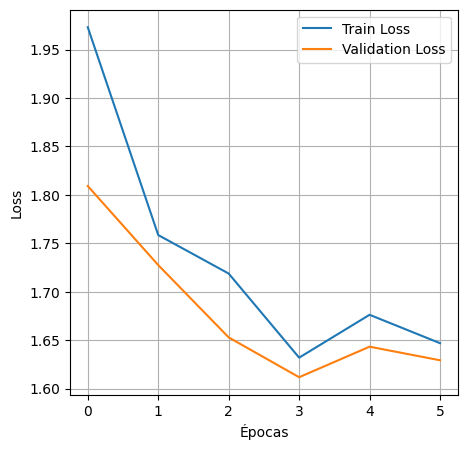

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.plot(train_loss_final, label='Train Loss')
plt.plot(val_loss_final, label='Validation Loss')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.grid()

In [ ]:
#Avaliação de diversidade com métricas Distinct-n

#Verifica se recurso 'punkt' do NLTK está disponível, caso contrário, faz o download
try:
    nltk.data.find('tokenizers/punkt')
except nltk.downloader.DownloadError:
    nltk.download('punkt')


def calcular_distinct_n(texto: str, n: int) -> float:
    """
    Calcula a métrica Distinct-n em um texto.
    - texto: string a ser avaliada
    - n: tamanho do n-gram

    Retorna um valor entre 0.0 e 1.0, representando a diversidade:
      Distinct-n = (# n-grams únicos) / (# total de n-grams)
    """
    if not texto.strip():
        return 0.0  #Texto vazio ou só espaços -> diversidade nula

    #Tokeniza o texto em palavras.
    tokens = word_tokenize(texto.lower())

    if len(tokens) < n:
        return 0.0  #Não há tokens suficientes para formar n-gramas

    #Gera lista de n-gramas, sendo tamanho dependente de n
    n_grams = list(ngrams(tokens, n))
    if not n_grams:
        return 0.0

    #Distinct-n = número de n-grams únicos dividido pelo total
    return len(set(n_grams)) / len(n_grams)


# Define a semente inicial para a geração
semente = "the king"

texto_gerado = generate(model, seed=semente, length=400, temperature=0.5)

print(f"\n--- Texto Gerado (semente: '{semente}') ---")
print(texto_gerado)
print("-" * 50)

#Calcula diversidade de unigramas (Distinct-1) e bigramas (Distinct-2)
distinct_1 = calcular_distinct_n(texto_gerado, 1)
distinct_2 = calcular_distinct_n(texto_gerado, 2)

print(f"Distinct-1 (diversidade de palavras): {distinct_1:.4f}")
print(f"Distinct-2 (diversidade de pares de palavras): {distinct_2:.4f}")
print("="*50 + "\n")



--- Texto Gerado (semente: 'the king') ---
                                                                                            the king of him. so when the bases of the per below the land a and s do and result and found of the out the day. i do everything were libry, and he start and seemed a be a starting as we sat on the reminded and even as i saled the the started the stranged up and something and be a beginning and for a remard, for your other our lead about it are her the course and it in a could and a could be a far she was
--------------------------------------------------
Distinct-1 (diversidade de palavras): 0.5938
Distinct-2 (diversidade de pares de palavras): 0.9579



### Testes

In [ ]:
# model = tf.keras.models.load_model("char_model_best_final.keras")

seed = "the king"
print("Texto gerado:")
print(generate(model, seed, length=400, temperature=0.5))

Texto gerado:
                                                                                                                                                                                                the king of the consides of the procar not his person of the sent, and he had a little to the adder and the terms of the other arr to be a mother of the dieds of the cold to the awail, never be action as their over, and almost intense the open the horses had gaint from the died and contribution of the coloristic side the grow the deautiful the thung of the gried and me so for the dark side to see a point 


In [ ]:
seed = "the king"
print("Texto gerado:")
print(generate(model, seed, length=400, temperature=0.5))

Texto gerado:


In [ ]:
model = tf.keras.models.load_model("char_model_best_heavy.keras")

seed = "the king"
print("Texto gerado:")
print(generate(model, seed, length=400, temperature=0.5))